In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, skew, kurtosis
import os
import json
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score

In [2]:
candidate_ids = [1, 2, 3, 4, 5, 7, 9, 11, 12, 13, 15, 16, 18, 19, 20]
features = []
labels = []

offset_data = pd.read_excel("offset.xlsx")

mae_startle = pd.read_excel("mae_startle.xlsx")

In [3]:
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

for candidate_id in candidate_ids:
    candidate_str = f"{candidate_id:02d}"
    
    time = pd.read_csv(f"time_{candidate_str}.csv")
    eda = pd.read_csv(f"eda_{candidate_str}.csv")
    ecg = pd.read_csv(f"ecg_{candidate_str}.csv")
    qrs = pd.read_csv(f"qrs_{candidate_str}.csv")
    
    offset_row = offset_data[offset_data['ID'] == candidate_id]
    simulator_offset = offset_row['Offset (simulator_start - fiziologija_start)'].values[0]
    startle_offsets = offset_row[[  
        'Startle 1 (startle_start - simulator_start)',
        'Startle 2 (startle_start - simulator_start)',
        'Startle 3 (startle_start - simulator_start)'
    ]].values[0]
    startle_times = simulator_offset + startle_offsets
    
    processed_data = {
        "candidate_id": candidate_id,
        "offset": simulator_offset,
        "startle_times": startle_times.tolist(),  
        "eda": eda.iloc[:, 0].tolist(),  
        "time": time.iloc[:, 0].tolist(),  
        "qrs": qrs.iloc[:, 0].tolist(),  
        "ecg": ecg.iloc[:, 0].tolist() 
    }
    
    with open(os.path.join(output_dir, f"candidate_{candidate_str}.json"), "w") as f:
        json.dump(processed_data, f)

print(f"Podaci za sve kandidate su spremljeni u folderu {output_dir}.")



Podaci za sve kandidate su spremljeni u folderu processed_data.


# 10. - 12. slajd

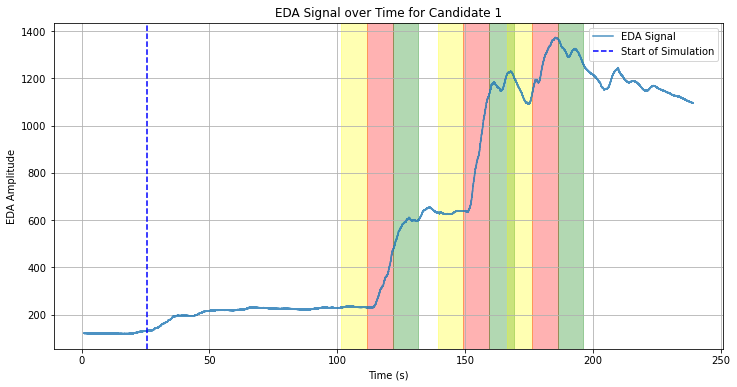

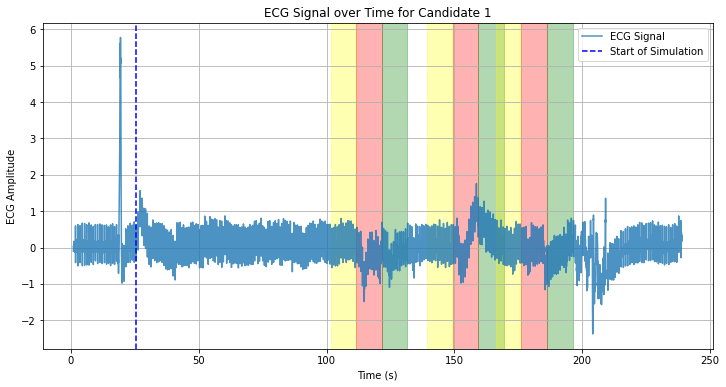

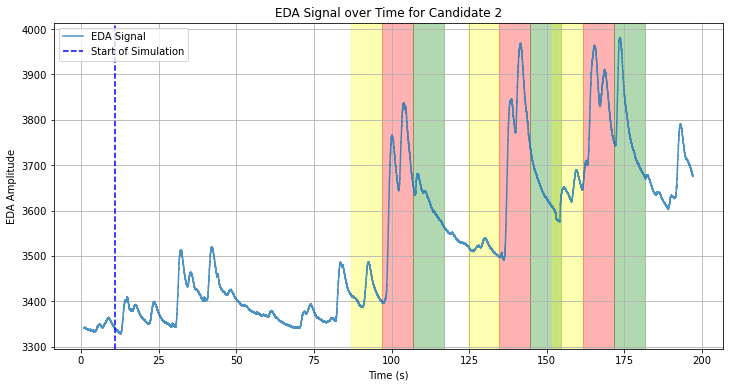

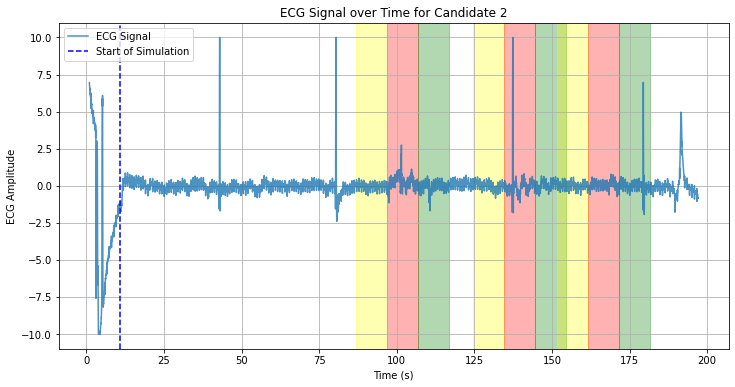

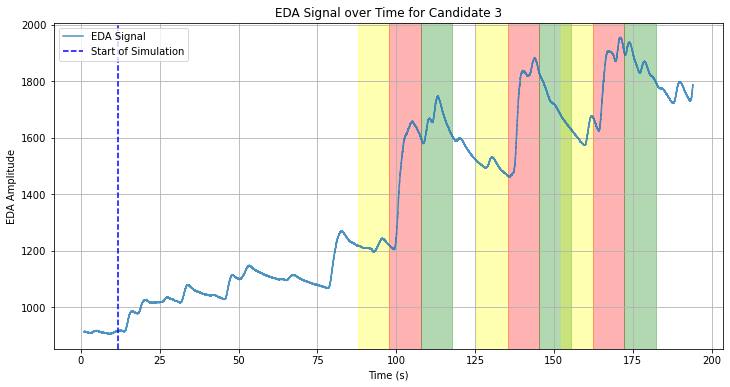

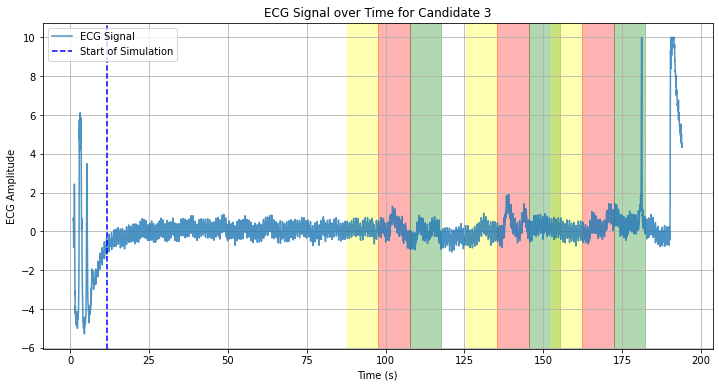

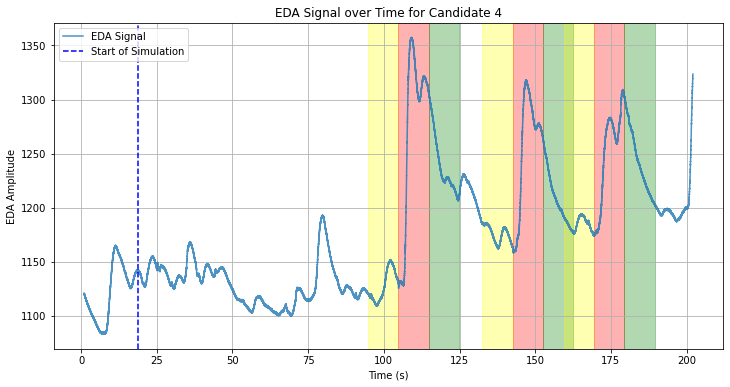

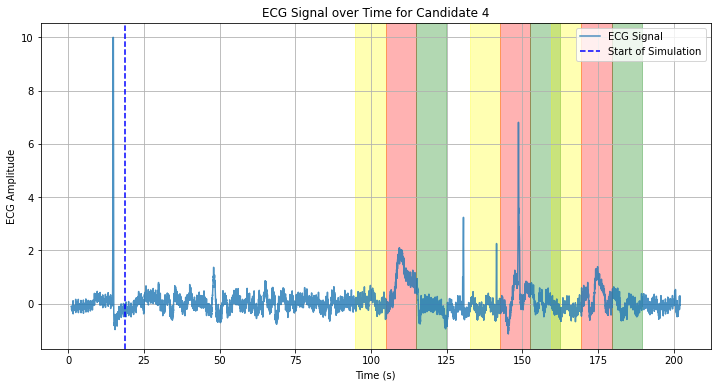

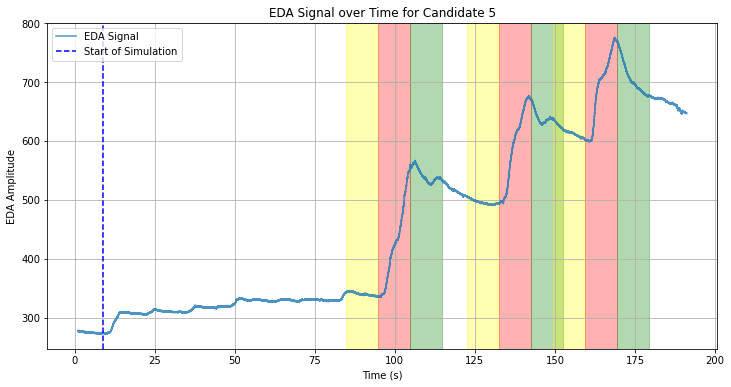

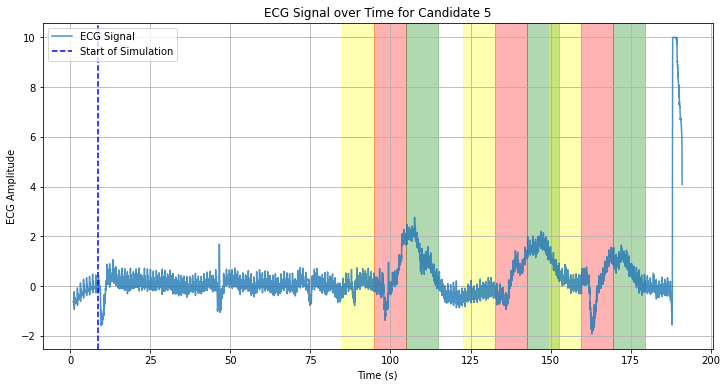

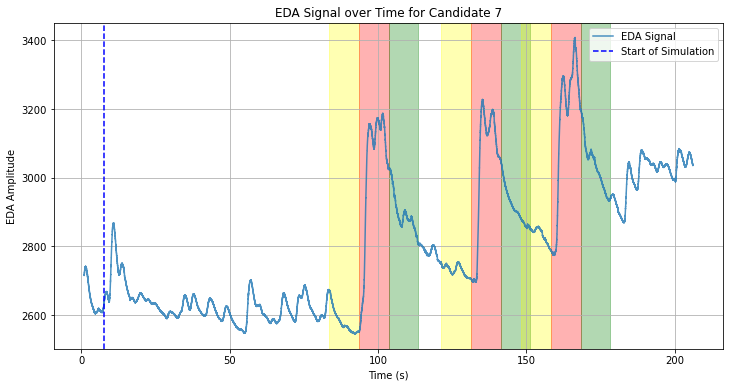

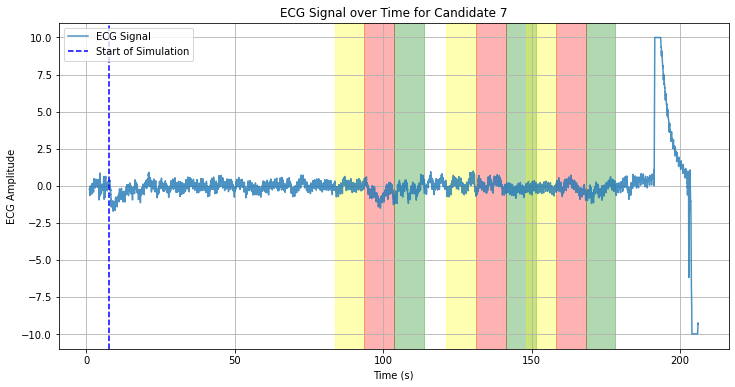

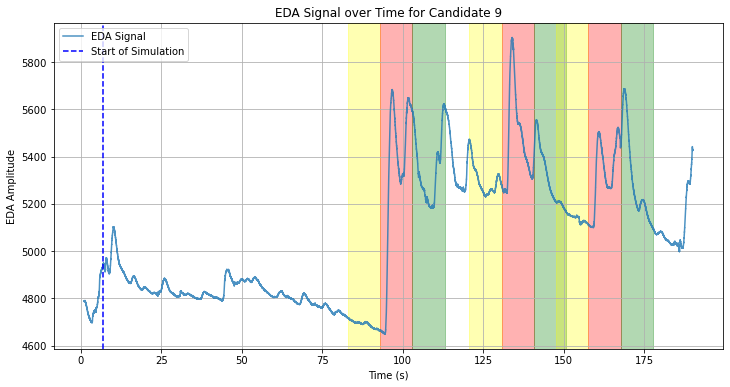

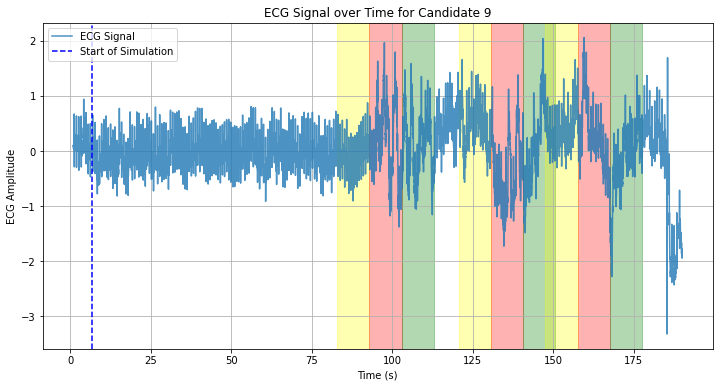

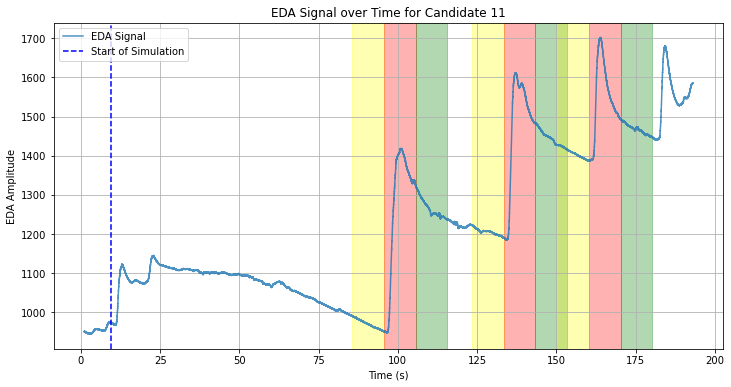

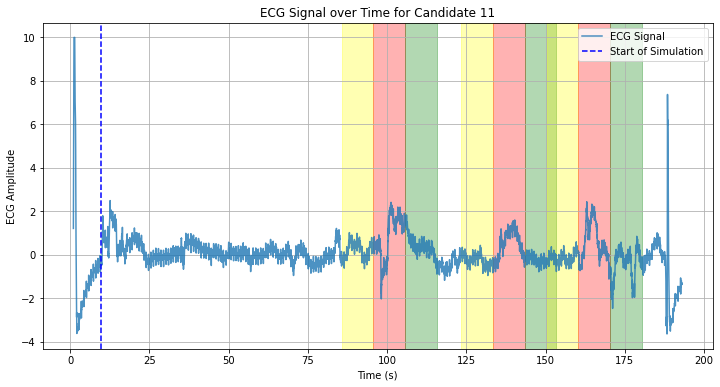

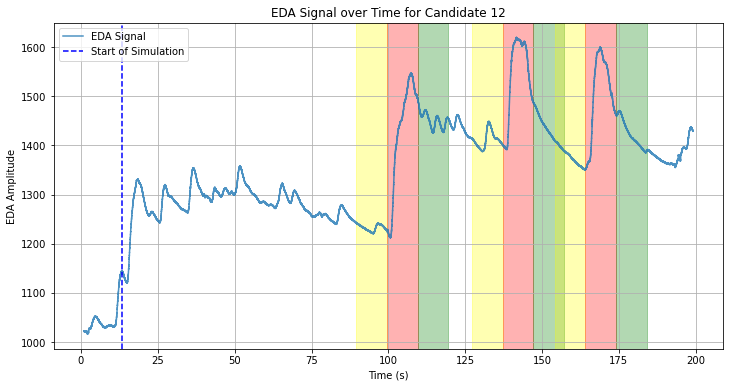

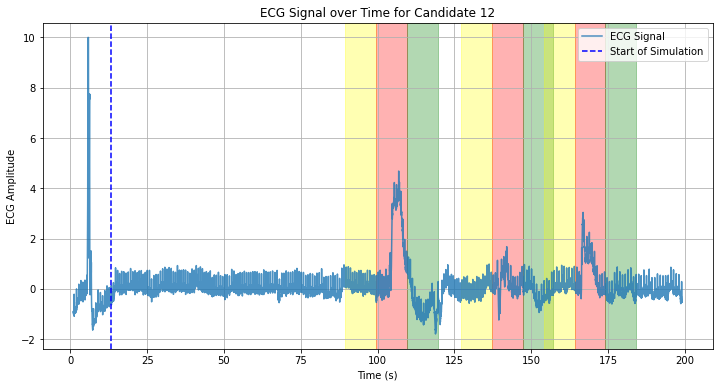

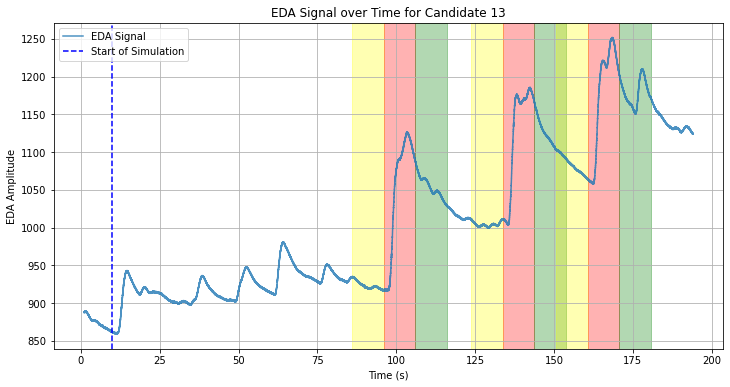

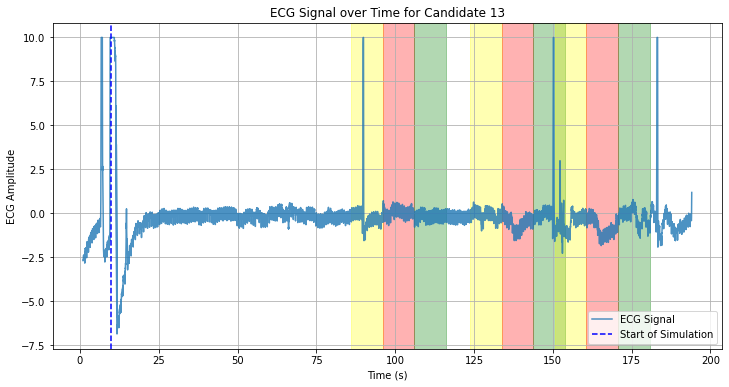

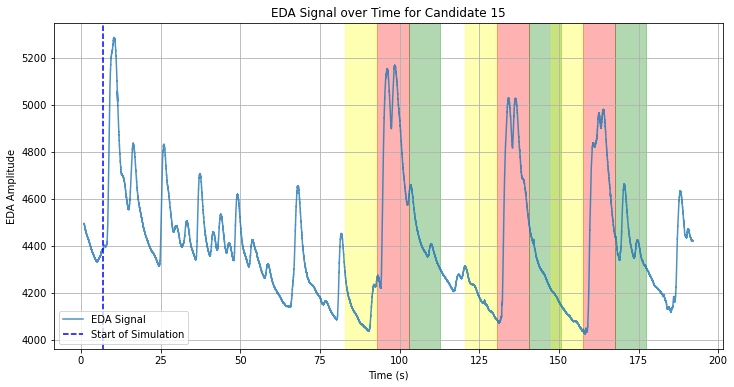

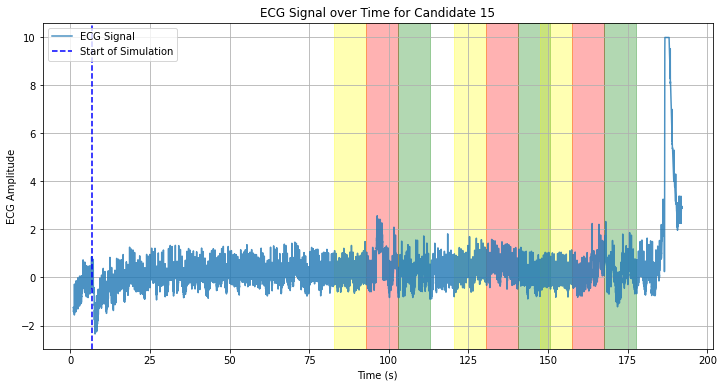

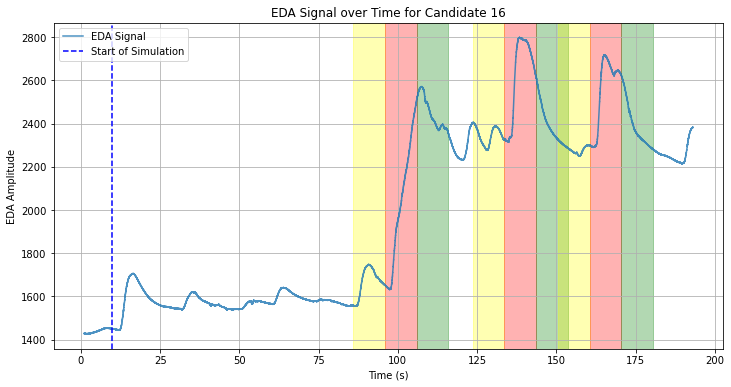

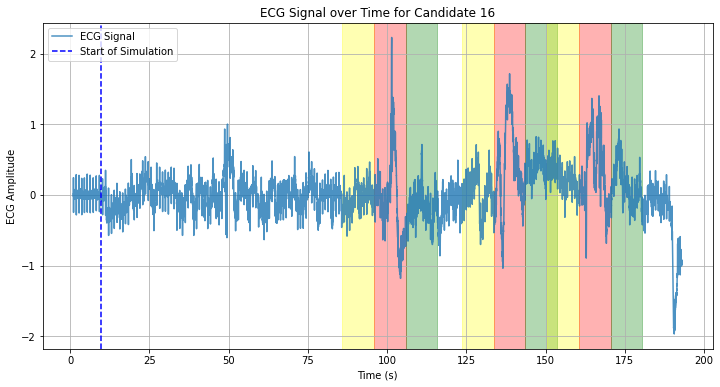

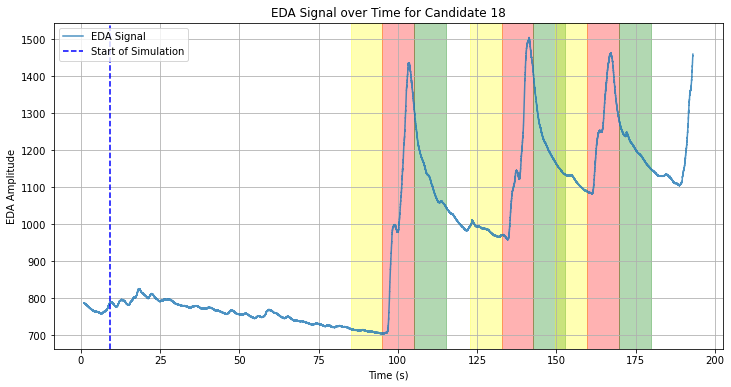

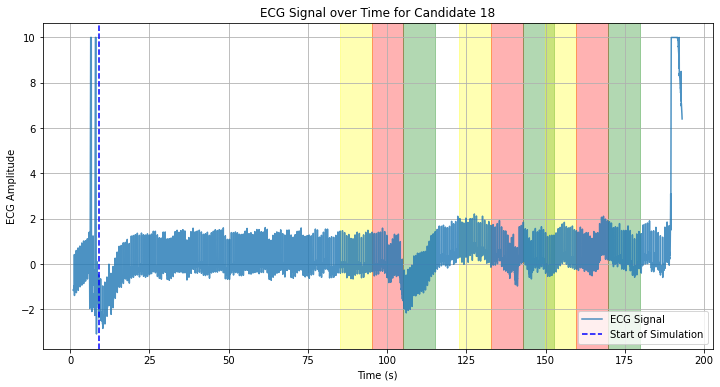

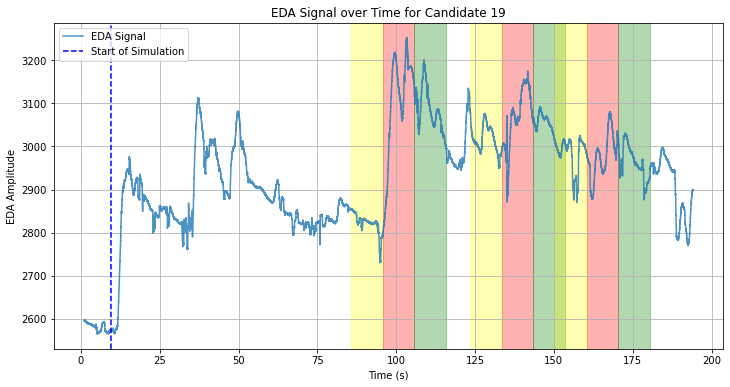

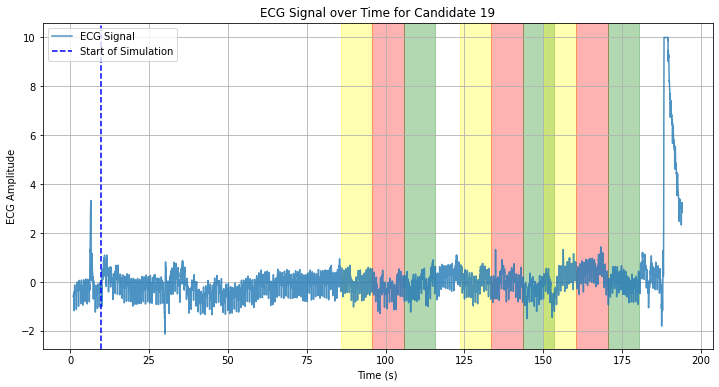

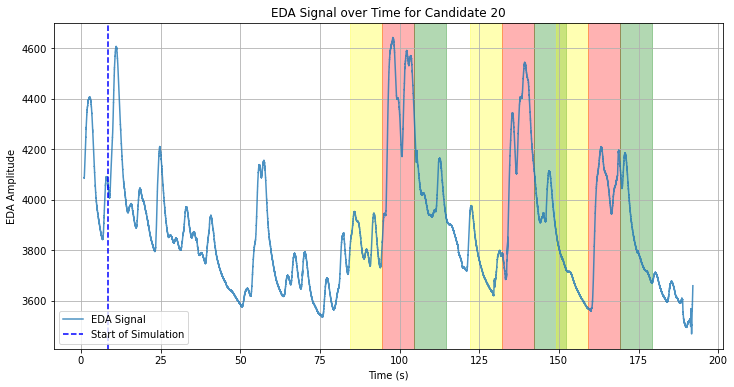

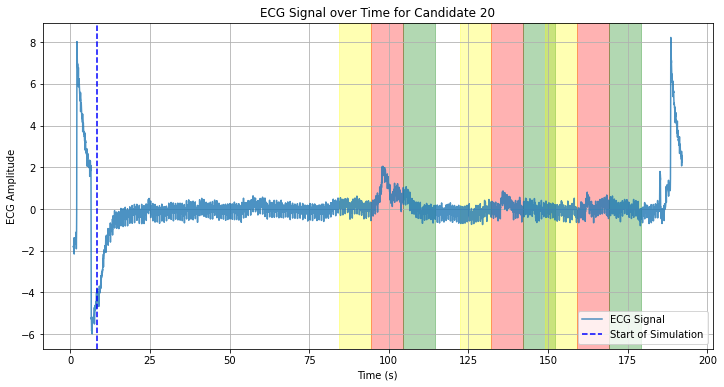

In [4]:
output_dir = "processed_data"

processed_files = [f for f in os.listdir(output_dir) if f.endswith('.json')]

for file in processed_files:
    with open(os.path.join(output_dir, file), "r") as f:
        data = json.load(f)
    
    candidate_id = data["candidate_id"]
    time = np.array(data["time"])
    eda = np.array(data["eda"])
    ecg = np.array(data["ecg"]) 
    startle_times = np.array(data["startle_times"])
    simulator_offset = data["offset"]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, eda, label='EDA Signal', alpha=0.8)
    plt.axvline(x=simulator_offset, color='blue', linestyle='--', label='Start of Simulation')
    
    for startle_time in startle_times:
        intervals = {
            "pre_startle": (startle_time - 10, startle_time),
            "startle": (startle_time, startle_time + 10),
            "post_startle": (startle_time + 10, startle_time + 20)
        }
        for interval_name, (start, end) in intervals.items():
            color = {"pre_startle": "yellow", "startle": "red", "post_startle": "green"}.get(interval_name, "gray")
            plt.axvspan(start, end, alpha=0.3, color=color)
    
    plt.title(f'EDA Signal over Time for Candidate {candidate_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('EDA Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, ecg, label='ECG Signal', alpha=0.8)
    plt.axvline(x=simulator_offset, color='blue', linestyle='--', label='Start of Simulation')
    
    for startle_time in startle_times:
        intervals = {
            "pre_startle": (startle_time - 10, startle_time),
            "startle": (startle_time, startle_time + 10),
            "post_startle": (startle_time + 10, startle_time + 20)
        }
        for interval_name, (start, end) in intervals.items():
            color = {"pre_startle": "yellow", "startle": "red", "post_startle": "green"}.get(interval_name, "gray")
            plt.axvspan(start, end, alpha=0.3, color=color)
    
    plt.title(f'ECG Signal over Time for Candidate {candidate_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('ECG Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


# 14. slajd

In [5]:
#IBI = razlika između uzastopnih qrs vremenskih oznaka (otkucaja srca)

#HRV (Heart Rate Variability) koristi razlike između uzastopnih IBI vrijednosti
    #SDNN (Standardna devijacija IBI intervala)
    #RMSSD (Kvadratni korijen srednje kvadratične razlike uzastopnih IBI intervala)


processed_files = [f for f in os.listdir(output_dir) if f.endswith('.json')]

all_features = []

for file in processed_files:
    with open(os.path.join(output_dir, file), "r") as f:
        data = json.load(f)
    
    candidate_id = data["candidate_id"]
    time = np.array(data["time"])
    eda = np.array(data["eda"])
    qrs = np.array(data["qrs"])
    ecg = np.array(data["ecg"])
    startle_times = np.array(data["startle_times"])
    
    for i, startle_time in enumerate(startle_times, start=1):
        intervals = {
            "pre_startle": (startle_time - 10, startle_time),
            "startle": (startle_time, startle_time + 10),
            "post_startle": (startle_time + 10, startle_time + 20)
        }
        
        for interval_name, (start, end) in intervals.items():
            eda_segment = eda[(time >= start) & (time <= end)]
            eda_mean = eda_segment.mean() if len(eda_segment) > 0 else 0
            eda_std = eda_segment.std() if len(eda_segment) > 0 else 0
            eda_slope = (eda_segment[-1] - eda_segment[0]) / (end - start) if len(eda_segment) > 1 else 0
            eda_range = eda_segment.max() - eda_segment.min() if len(eda_segment) > 0 else 0
            
            qrs_segment = qrs[(qrs >= start) & (qrs <= end)]
            ibi_intervals = np.diff(qrs_segment) if len(qrs_segment) > 1 else []
            ibi_mean = np.mean(ibi_intervals) if len(ibi_intervals) > 0 else 0
            ibi_std = np.std(ibi_intervals) if len(ibi_intervals) > 0 else 0
            ibi_slope = (ibi_intervals[-1] - ibi_intervals[0]) / len(ibi_intervals) if len(ibi_intervals) > 1 else 0
            hrv_sdnn = np.std(ibi_intervals) if len(ibi_intervals) > 0 else 0
            hrv_rmssd = np.sqrt(np.mean(np.square(np.diff(ibi_intervals)))) if len(ibi_intervals) > 1 else 0
            
          
            feature_vector = {
                "Candidate": candidate_id,
                "Startle": i,
                "Interval": interval_name,
                "IBI_Mean": ibi_mean,
                "IBI_Std": ibi_std,
                "IBI_Slope": ibi_slope,
                "HRV_SDNN": hrv_sdnn,
                "HRV_RMSSD": hrv_rmssd,
                "EDA_Mean": eda_mean,
                "EDA_Std": eda_std,
                "EDA_Slope": eda_slope,
                "EDA_Range": eda_range, 
                "mae_value": 0
            }
            all_features.append(feature_vector)

features_df = pd.DataFrame(all_features)
print(features_df)


     Candidate  Startle      Interval  IBI_Mean   IBI_Std  IBI_Slope  \
0            1        1   pre_startle  0.704060  0.054429   0.011966   
1            1        1       startle  0.745833  0.047918   0.003241   
2            1        1  post_startle  0.774306  0.032752   0.008565   
3            1        2   pre_startle  0.768519  0.030980   0.003472   
4            1        2       startle  0.753704  0.039436  -0.009722   
..         ...      ...           ...       ...       ...        ...   
130         20        2       startle  0.682342  0.030118  -0.006051   
131         20        2  post_startle  0.700595  0.028390   0.005849   
132         20        3   pre_startle  0.683325  0.016373  -0.002484   
133         20        3       startle  0.668841  0.019387  -0.005802   
134         20        3  post_startle  0.668000  0.039528   0.004135   

     HRV_SDNN  HRV_RMSSD     EDA_Mean     EDA_Std  EDA_Slope   EDA_Range  \
0    0.054429   0.055740   233.014496    1.375529  -0.06103

# 15. slajd

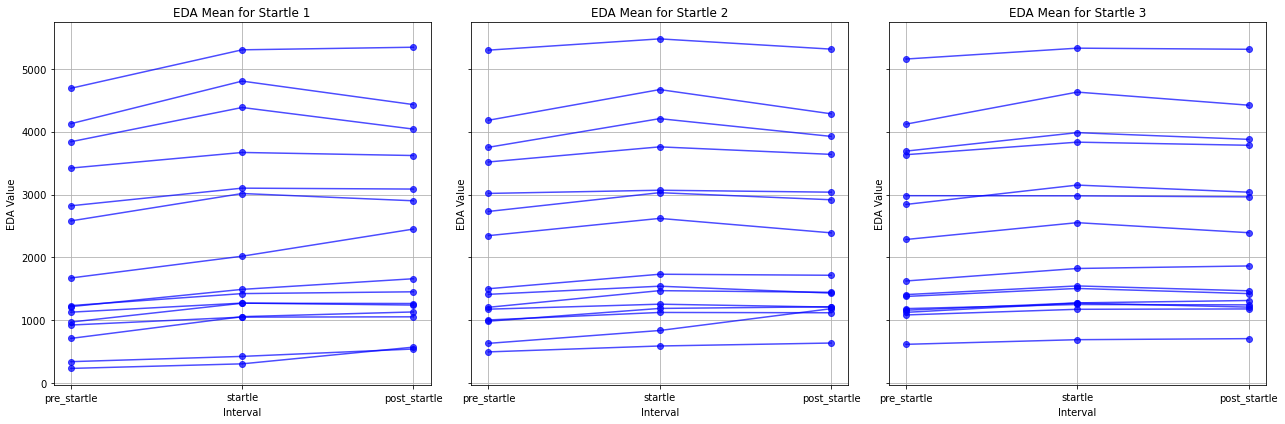

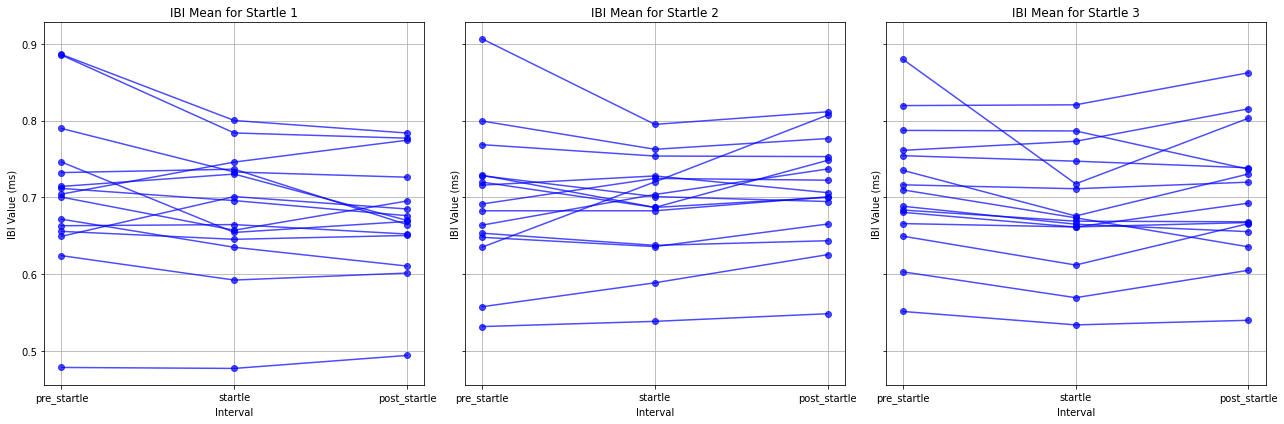

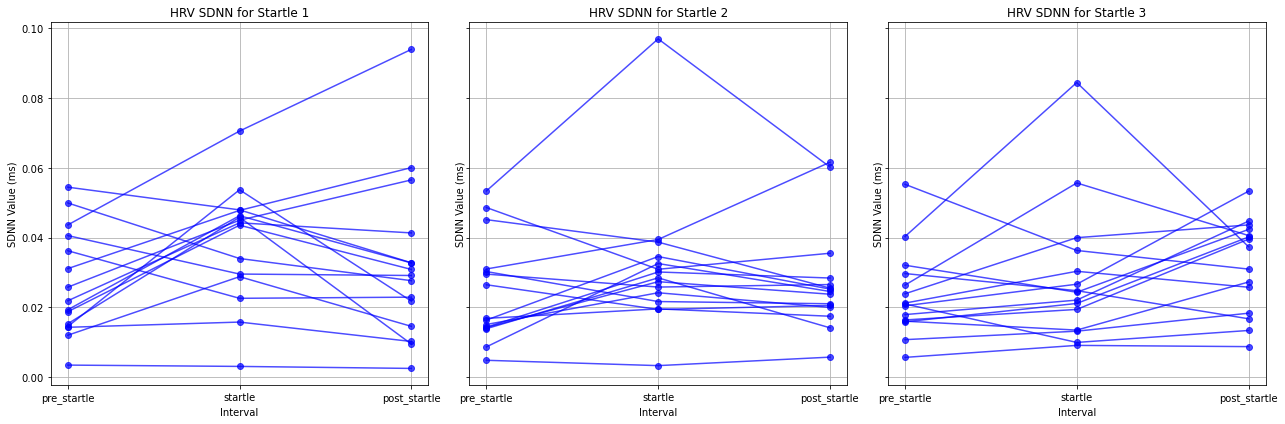

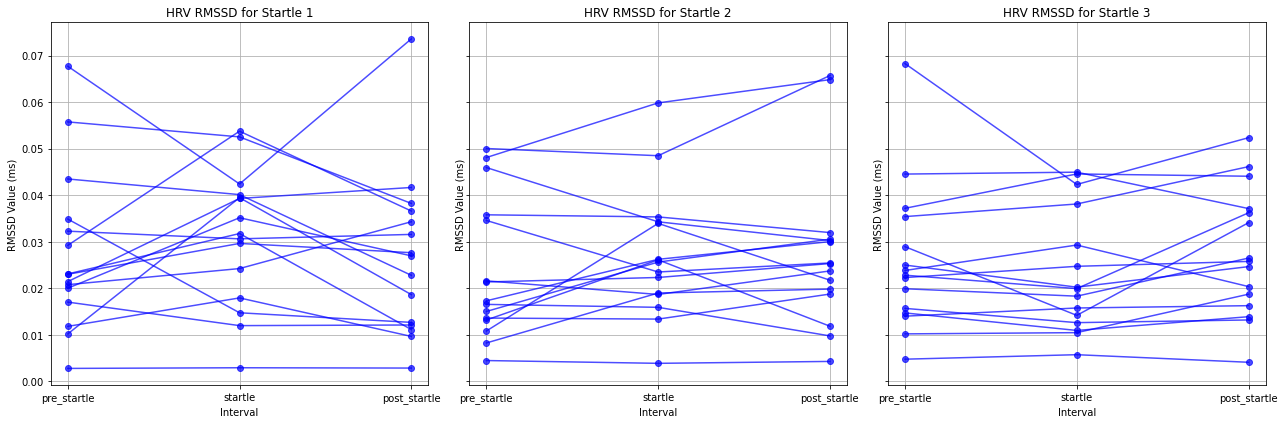

In [6]:
intervals = ["pre_startle", "startle", "post_startle"]

def plot_feature_for_all_candidates(feature_name, ylabel, column_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for startle_type, ax in zip([1, 2, 3], axes):
        for candidate_id in features_df['Candidate'].unique():
            physiological_data = features_df[
                (features_df['Candidate'] == candidate_id) & (features_df['Startle'] == startle_type)
            ].set_index('Interval').loc[intervals, [column_name]]

            values = physiological_data[column_name]
            
            ax.plot(intervals, values, marker='o', label=f'Candidate {candidate_id}', color='blue', alpha=0.7)

        ax.set_title(f'{feature_name} for Startle {startle_type}', fontsize=12)
        ax.set_xlabel('Interval', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xticks(intervals)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_feature_for_all_candidates('EDA Mean', 'EDA Value', 'EDA_Mean')
plot_feature_for_all_candidates('IBI Mean', 'IBI Value (ms)', 'IBI_Mean')
plot_feature_for_all_candidates('HRV SDNN', 'SDNN Value (ms)', 'HRV_SDNN')
plot_feature_for_all_candidates('HRV RMSSD', 'RMSSD Value (ms)', 'HRV_RMSSD')


# 16.slajd

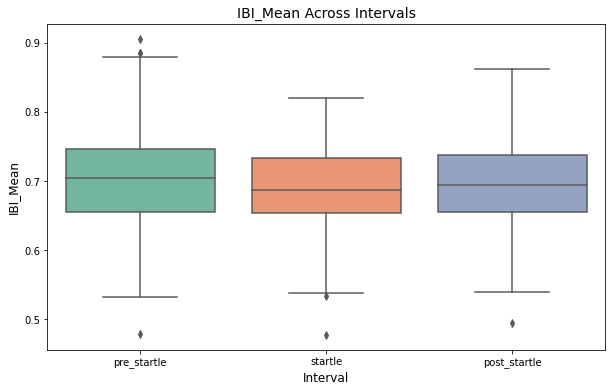

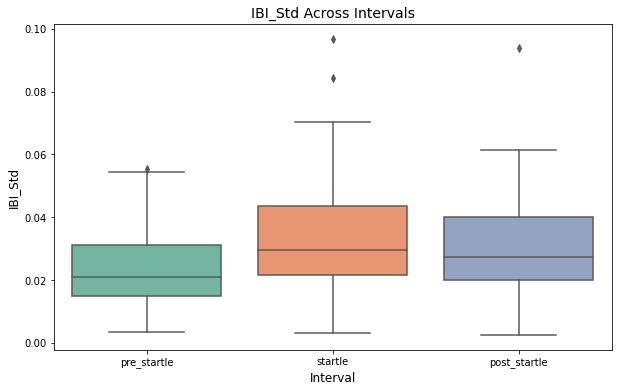

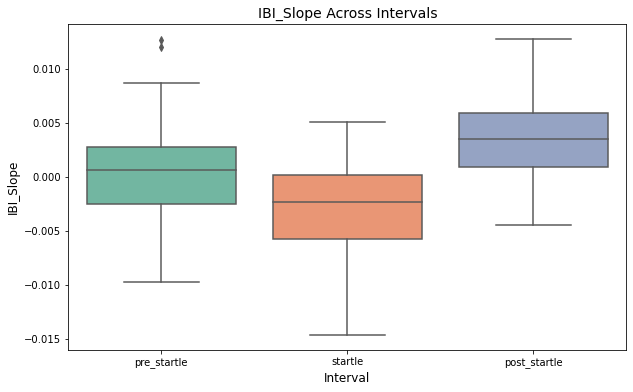

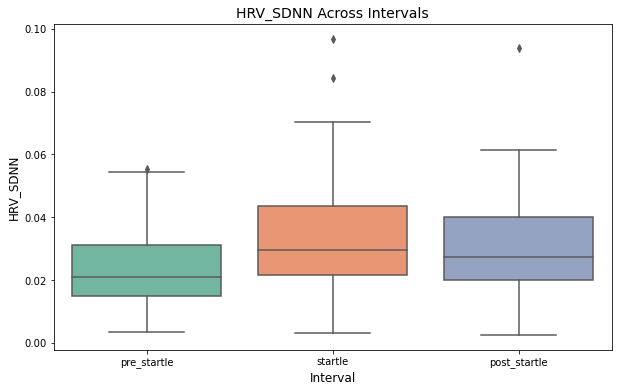

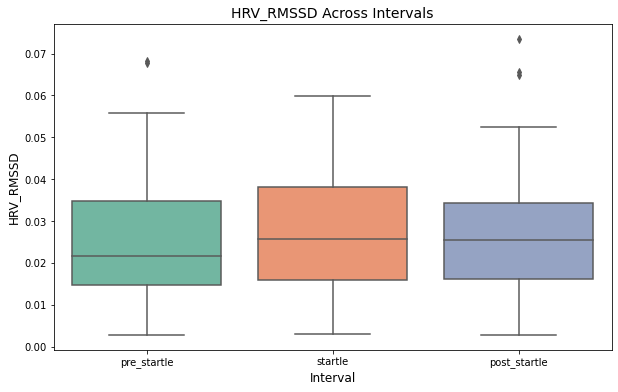

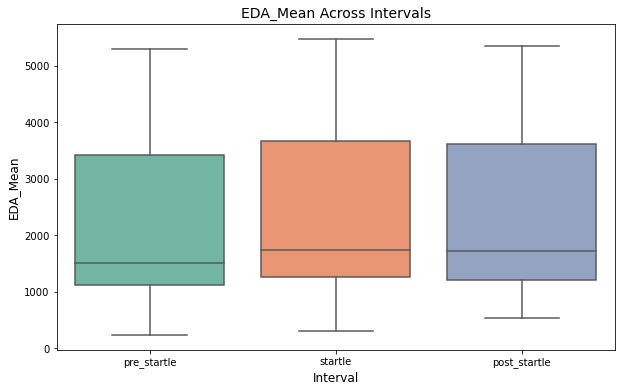

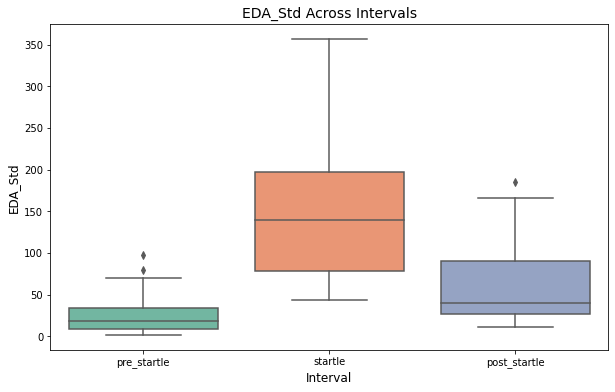

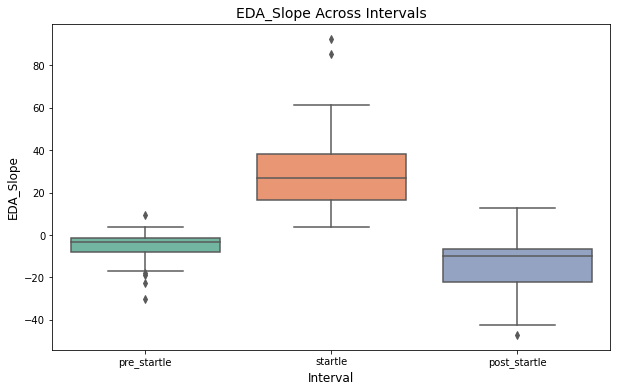

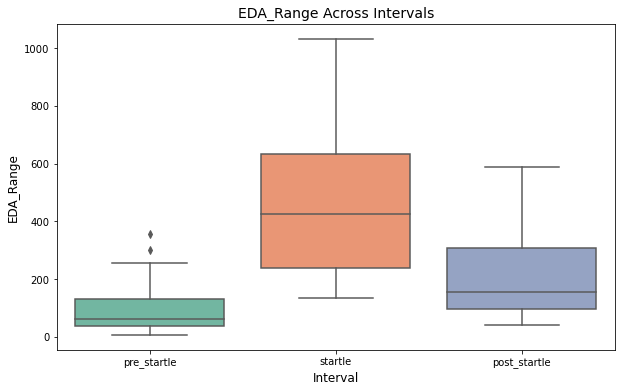

In [7]:
features = ['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN'
           , 'HRV_RMSSD', 'EDA_Mean', 'EDA_Std', 'EDA_Slope', 'EDA_Range']

df = features_df
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df, 
        x='Interval', 
        y=feature, 
        palette='Set2'
    )
    plt.title(f'{feature} Across Intervals', fontsize=14)
    plt.xlabel('Interval', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.show()

In [8]:
all_features = pd.DataFrame()

for candidate_id in candidate_ids:
    mae_for_candidate = mae_startle[mae_startle['ID'] == candidate_id]
    intervals = ['PRE-STARTLE', 'STARTLE', 'POST-STARTLE']
    startles = [1, 2, 3]
    features = features_df[
            (features_df['Candidate'] == candidate_id)].copy()
    for i in range(9):
        current_row = features.iloc[i]
        interval = current_row['Interval'].upper()
        interval = interval.upper()
        interval = interval.replace('_', '-')
        startle = str(current_row['Startle'])
        features['mae_value'] = features.apply(
        lambda row: mae_for_candidate.get(f"{row['Interval'].upper().replace('_', '-')} {int(row['Startle'])}").values[0]
        if f"{row['Interval'].upper().replace('_', '-')} {int(row['Startle'])}" in mae_for_candidate else None,
        axis=1
    )#features.loc[i, 'mae_value'] = mae_for_candidate[f'{interval} {startle}'].values[0]
    all_features = pd.concat([all_features, features], ignore_index=True)


print(all_features)


     Candidate  Startle      Interval  IBI_Mean   IBI_Std  IBI_Slope  \
0            1        1   pre_startle  0.704060  0.054429   0.011966   
1            1        1       startle  0.745833  0.047918   0.003241   
2            1        1  post_startle  0.774306  0.032752   0.008565   
3            1        2   pre_startle  0.768519  0.030980   0.003472   
4            1        2       startle  0.753704  0.039436  -0.009722   
..         ...      ...           ...       ...       ...        ...   
130         20        2       startle  0.682342  0.030118  -0.006051   
131         20        2  post_startle  0.700595  0.028390   0.005849   
132         20        3   pre_startle  0.683325  0.016373  -0.002484   
133         20        3       startle  0.668841  0.019387  -0.005802   
134         20        3  post_startle  0.668000  0.039528   0.004135   

     HRV_SDNN  HRV_RMSSD     EDA_Mean     EDA_Std  EDA_Slope   EDA_Range  \
0    0.054429   0.055740   233.014496    1.375529  -0.06103

In [9]:
all_features_df = pd.DataFrame(all_features)

numerical_features_all = all_features_df.select_dtypes(include=['float64', 'int64']).drop(columns=['Candidate', 'Startle'], errors='ignore')

correlation_matrix_all = numerical_features_all.corr(method='spearman')

#print("Korelacijska matrica za numeričke stupce:")
#print(correlation_matrix_all)

# 17.slajd

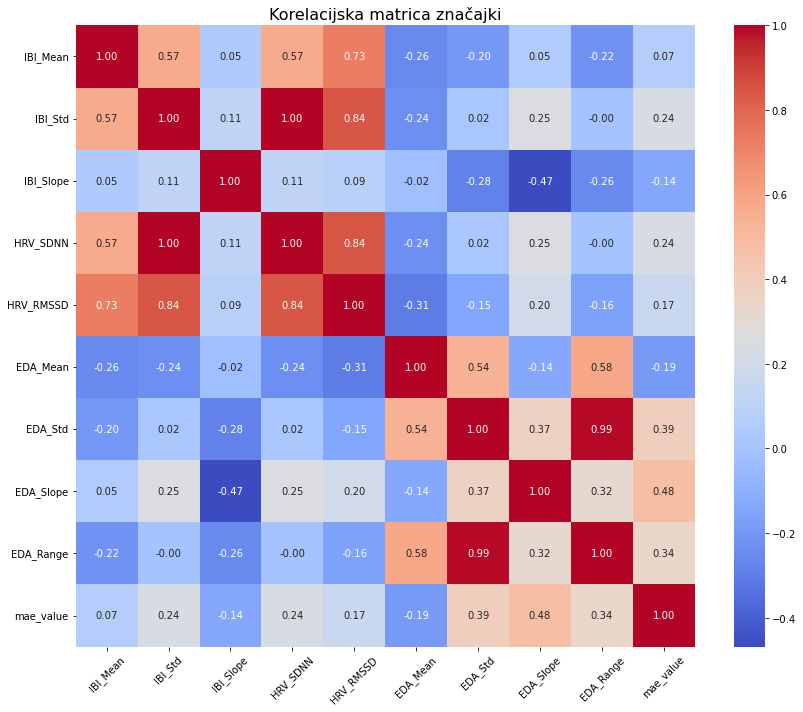

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Korelacijska matrica značajki", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 19.slajd

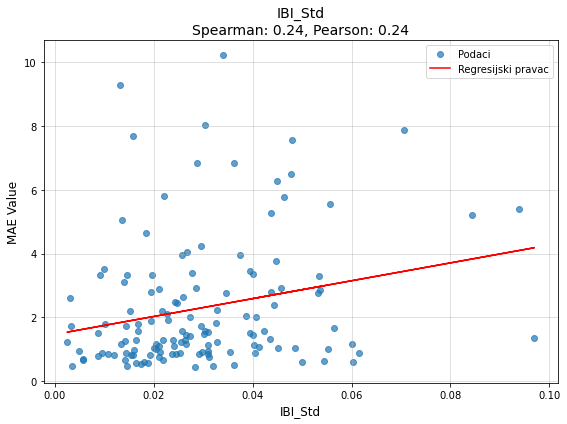

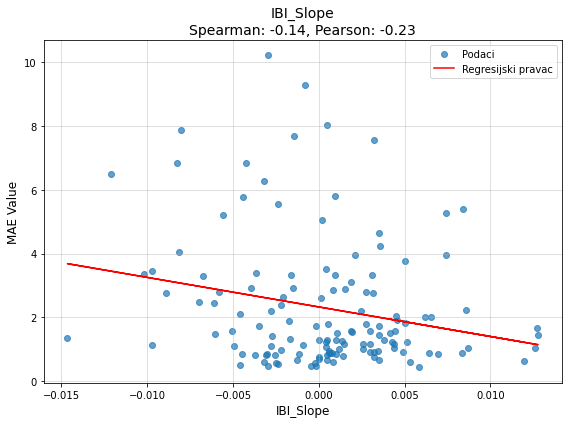

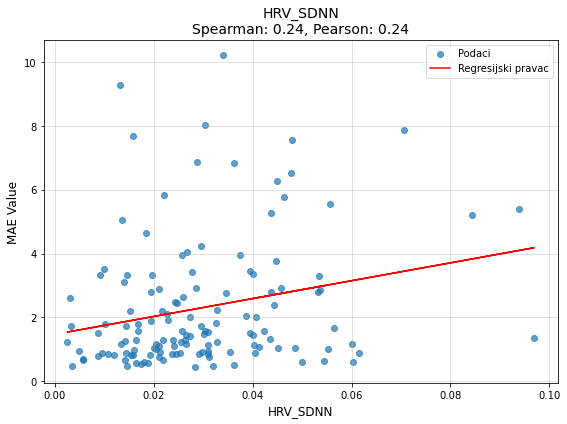

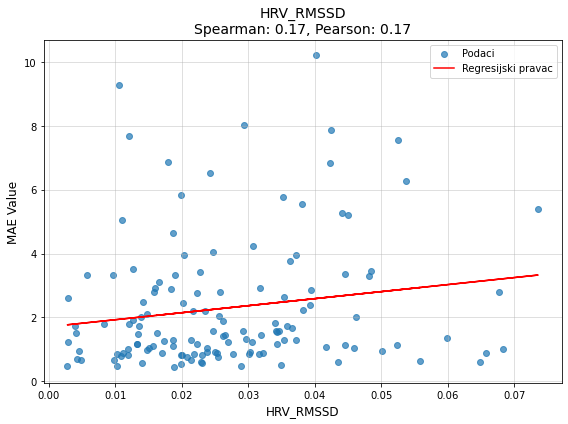

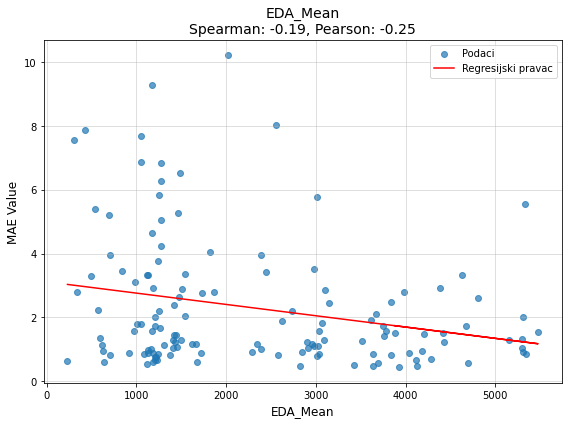

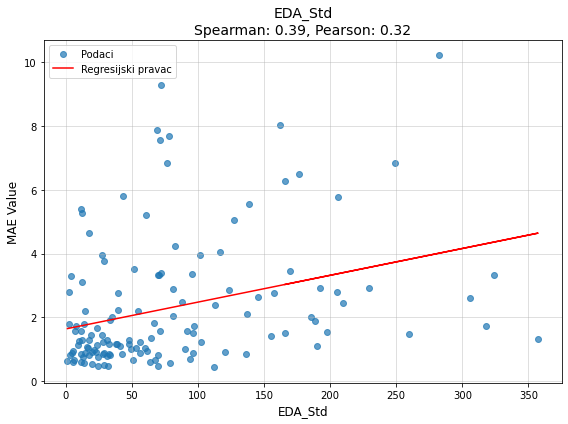

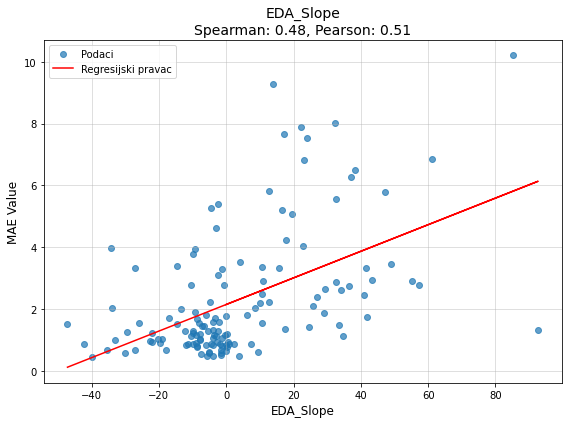

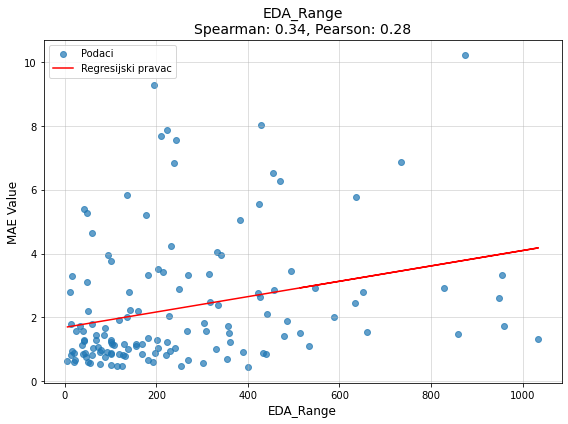

In [11]:
features_to_plot = ['IBI_Std', 'IBI_Slope', 'HRV_SDNN', 'HRV_RMSSD',
                    'EDA_Mean', 'EDA_Std', 'EDA_Slope', 'EDA_Range']

for feature in features_to_plot:
    if feature in all_features.columns:  
        spearman_corr, _ = spearmanr(all_features[feature], all_features['mae_value'])
        pearson_corr, _ = pearsonr(all_features[feature], all_features['mae_value'])

        plt.figure(figsize=(8, 6))
        plt.scatter(all_features[feature], all_features['mae_value'], alpha=0.7, label='Podaci')

        m, b = np.polyfit(all_features[feature], all_features['mae_value'], 1)  
        plt.plot(all_features[feature], m * all_features[feature] + b, color='red', label='Regresijski pravac')

        plt.title(f'{feature}\nSpearman: {spearman_corr:.2f}, Pearson: {pearson_corr:.2f}', fontsize=14)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('MAE Value', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()


# 22. slajd prvi model

In [12]:
df = mae_startle

startle_columns = [col for col in df.columns if "STARTLE" in col and "PRE" not in col and "POST" not in col]

all_startle_data = df[startle_columns].stack()

boundaries = pd.qcut(all_startle_data, q=3, labels=['Low', 'Medium', 'High'], retbins=True)[1]
print(f"Granice za sve Startle kolone zajedno:")
print(f"Low do Medium: {boundaries[0]:.2f} - {boundaries[1]:.2f}")
print(f"Medium do High: {boundaries[1]:.2f} - {boundaries[2]:.2f}")
print(f"High do Max: {boundaries[2]:.2f} - {boundaries[3]:.2f}")
print("-" * 30)

for col in startle_columns:
    df[f'{col}_category'] = pd.cut(
        df[col],
        bins=boundaries,
        labels=['Low', 'Medium', 'High'],
        include_lowest=True
    )

#print(df)

Granice za sve Startle kolone zajedno:
Low do Medium: 1.12 - 2.57
Medium do High: 2.57 - 4.50
High do Max: 4.50 - 10.21
------------------------------


In [13]:
filtered_features = all_features[all_features['Interval'] == 'startle'].copy()

def get_category(row):
    candidate_id = row['Candidate']
    startle_num = row['Startle']
    category_column = f"STARTLE {startle_num}_category"
    return df.loc[df['ID'] == candidate_id, category_column].values[0]

filtered_features['Category'] = filtered_features.apply(get_category, axis=1)

print(filtered_features)


     Candidate  Startle Interval  IBI_Mean   IBI_Std  IBI_Slope  HRV_SDNN  \
1            1        1  startle  0.745833  0.047918   0.003241  0.047918   
4            1        2  startle  0.753704  0.039436  -0.009722  0.039436   
7            1        3  startle  0.747009  0.036288  -0.008282  0.036288   
10           2        1  startle  0.654135  0.022576  -0.004595  0.022576   
13           2        2  startle  0.686738  0.027344  -0.002746  0.027344   
16           2        3  startle  0.675615  0.024313  -0.007000  0.024313   
19           3        1  startle  0.695635  0.047770  -0.012103  0.047770   
22           3        2  startle  0.686706  0.034538  -0.008929  0.034538   
25           3        3  startle  0.673214  0.026615  -0.008135  0.026615   
28           4        1  startle  0.730197  0.029525   0.003556  0.029525   
31           4        2  startle  0.700855  0.021646  -0.002786  0.021646   
34           4        3  startle  0.664881  0.022059   0.000960  0.022059   

In [14]:
numeric_columns = ['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN', 'HRV_RMSSD', 
                   'EDA_Mean', 'EDA_Std', 'EDA_Slope', 'EDA_Range', 'mae_value']

correlation_matrix = filtered_features[numeric_columns].corr()

#print(correlation_matrix)

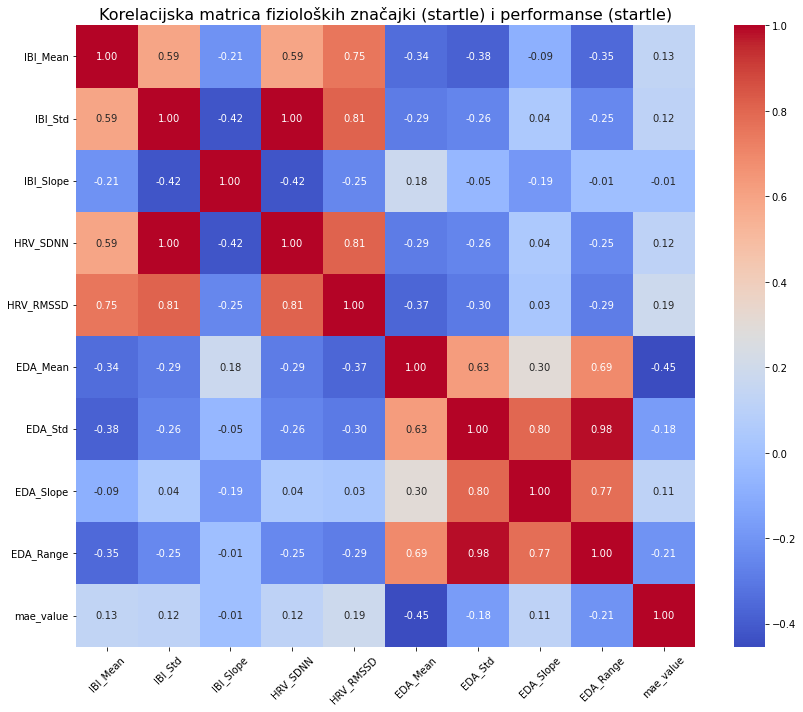

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Korelacijska matrica fizioloških značajki (startle) i performanse (startle)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 22. slajd prvi model - logo

In [16]:
X = filtered_features[['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN',
                       'HRV_RMSSD', 'EDA_Mean', 'EDA_Std', 'EDA_Range']]
y = filtered_features['Category']
candidates = filtered_features['Candidate']

lda = LinearDiscriminantAnalysis()

# Leave-One-Group-Out Cross-Validation 
logo = LeaveOneGroupOut()  
accuracies = []
predictions = []  

for train_index, test_index in logo.split(X, y, groups=candidates):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lda.fit(X_train, y_train)
    
    y_pred = lda.predict(X_test)
    
    predictions.extend(y_pred)  
    
    accuracies.append(accuracy_score(y_test, y_pred))  

mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Prosječna točnost LDA modela s LOO-GO: {mean_accuracy:.2f}")

filtered_features['Predicted_Category'] = predictions
#print(filtered_features)

Prosječna točnost LDA modela s LOO-GO: 0.24


# 22. slajd prvi model - loo

In [17]:
X = filtered_features[['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN'
                      ,'HRV_RMSSD', 'EDA_Mean', 'EDA_Std', 'EDA_Range'
                      ]]
y = filtered_features['Category']
candidates = filtered_features['Candidate']

lda = LinearDiscriminantAnalysis()

loo = LeaveOneOut()
accuracies = []
predictions = [] 

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lda.fit(X_train, y_train)
    
    y_pred = lda.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    predictions.append(y_pred[0])  
    

mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Prosječna točnost LDA modela s LOOCV: {mean_accuracy:.2f}")


filtered_features['Predicted_Category'] = predictions
#print(filtered_features)

Prosječna točnost LDA modela s LOOCV: 0.27


In [18]:
result = filtered_features.groupby('Candidate').agg(
    most_common_category=('Category', lambda x: x.mode().iloc[0]),
    most_common_predicted_category=('Predicted_Category', lambda x: x.mode().iloc[0])
).reset_index()


accuracy = (result['most_common_category'] == result['most_common_predicted_category']).mean() * 100

print(f'Accuracy: {accuracy:.2f}%')
print(result)



Accuracy: 46.67%
    Candidate most_common_category most_common_predicted_category
0           1                 High                           High
1           2                  Low                            Low
2           3               Medium                           High
3           4                 High                         Medium
4           5                 High                           High
5           7                  Low                            Low
6           9                  Low                            Low
7          11               Medium                         Medium
8          12                  Low                           High
9          13                 High                         Medium
10         15               Medium                            Low
11         16                 High                           High
12         18                 High                         Medium
13         19               Medium                         

# 25. slajd

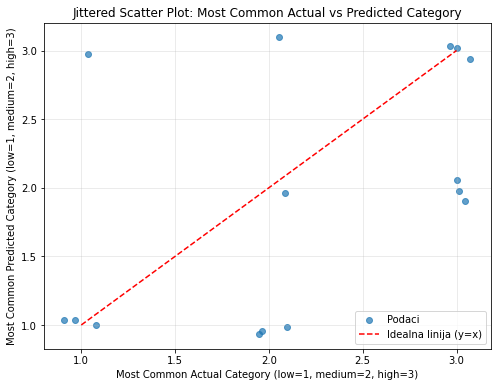

In [19]:
category_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
result['most_common_category_numeric'] = result['most_common_category'].map(category_mapping)
result['most_common_predicted_category_numeric'] = result['most_common_predicted_category'].map(category_mapping)


jitter_strength = 0.1
actual_with_jitter = result['most_common_category_numeric'] + np.random.uniform(-jitter_strength, jitter_strength, len(result))
predicted_with_jitter = result['most_common_predicted_category_numeric'] + np.random.uniform(-jitter_strength, jitter_strength, len(result))

plt.figure(figsize=(8, 6))
plt.scatter(actual_with_jitter, predicted_with_jitter, alpha=0.7, label="Podaci")

x_range = np.linspace(1, 3, 100)
plt.plot(x_range, x_range, color='red', linestyle='--', label="Idealna linija (y=x)")

plt.title("Jittered Scatter Plot: Most Common Actual vs Predicted Category")
plt.xlabel("Most Common Actual Category (low=1, medium=2, high=3)")
plt.ylabel("Most Common Predicted Category (low=1, medium=2, high=3)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 22. slajd drugi model

In [20]:
# FIZIOLOŠKE ZNAČAJKE PRE_STARTLE -> PERFORMANSE STARTLE

filtered_features_pre = all_features[all_features['Interval'] == 'pre_startle'].copy()

startle_values = all_features[all_features['Interval'] == 'startle'][['Candidate', 'Startle', 'mae_value']]

filtered_features_pre = filtered_features_pre.merge(startle_values, how='left', on=['Candidate', 'Startle'], suffixes=('', '_startle'))


def get_category(row):
    candidate_id = row['Candidate']
    startle_num = row['Startle']
    category_column = f"STARTLE {startle_num}_category"
    return df.loc[df['ID'] == candidate_id, category_column].values[0]

filtered_features_pre['Category'] = filtered_features_pre.apply(get_category, axis=1)

print(filtered_features_pre)


    Candidate  Startle     Interval  IBI_Mean   IBI_Std     IBI_Slope  \
0           1        1  pre_startle  0.704060  0.054429  1.196581e-02   
1           1        2  pre_startle  0.768519  0.030980  3.472222e-03   
2           1        3  pre_startle  0.754167  0.055248  1.157407e-03   
3           2        1  pre_startle  0.745940  0.036212 -4.572650e-03   
4           2        2  pre_startle  0.728704  0.014206  1.351852e-03   
5           2        3  pre_startle  0.735043  0.032054 -4.273504e-04   
6           3        1  pre_startle  0.711538  0.031082  3.205128e-03   
7           3        2  pre_startle  0.719676  0.016334  4.629630e-04   
8           3        3  pre_startle  0.709615  0.020430  1.495726e-03   
9           4        1  pre_startle  0.714103  0.040554  6.410256e-04   
10          4        2  pre_startle  0.727991  0.030244  1.854701e-03   
11          4        3  pre_startle  0.688248  0.017908 -3.205128e-03   
12          5        1  pre_startle  0.885278  0.04

In [21]:
numeric_columns = ['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN', 'HRV_RMSSD', 
                   'EDA_Mean', 'EDA_Std', 'EDA_Slope', 'EDA_Range', 'mae_value_startle']


correlation_matrix = filtered_features_pre[numeric_columns].corr()

#print(correlation_matrix)

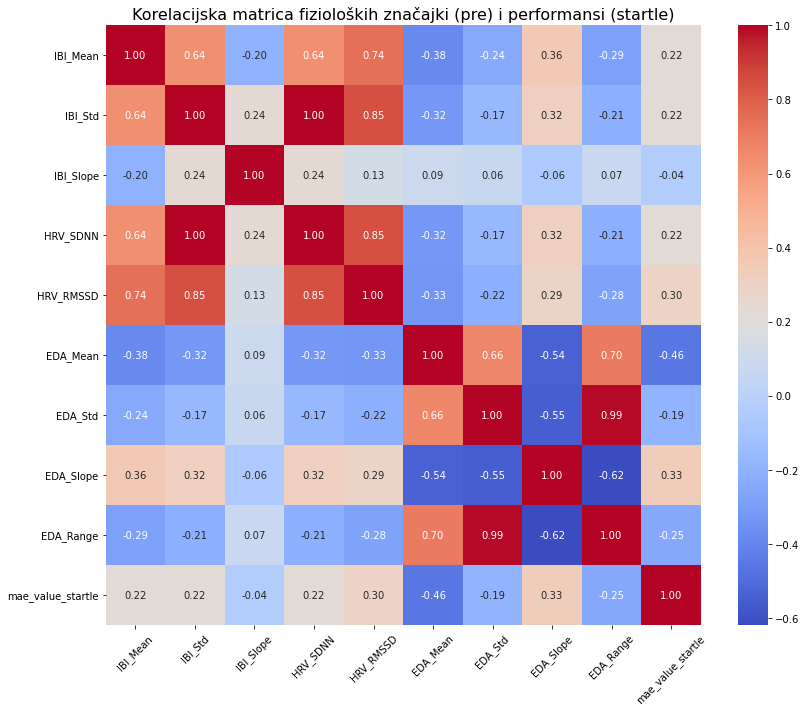

In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Korelacijska matrica fizioloških značajki (pre) i performansi (startle)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 22. slajd drugi model - logo

In [23]:
X = filtered_features_pre[['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN',
                       'HRV_RMSSD', 'EDA_Mean', 'EDA_Std', 'EDA_Range']]
y = filtered_features_pre['Category']
candidates = filtered_features_pre['Candidate']

lda = LinearDiscriminantAnalysis()

# Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()  
accuracies = []
predictions = [] 

for train_index, test_index in logo.split(X, y, groups=candidates):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lda.fit(X_train, y_train)
    
    y_pred = lda.predict(X_test)
    
    predictions.extend(y_pred) 
    
    accuracies.append(accuracy_score(y_test, y_pred))  

mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Prosječna točnost LDA modela s LOO-GO: {mean_accuracy:.2f}")

filtered_features_pre['Predicted_Category'] = predictions
#print(filtered_features_pre)

Prosječna točnost LDA modela s LOO-GO: 0.49


# 22. slajd drugi model - loo

In [24]:
X = filtered_features_pre[['IBI_Mean', 'IBI_Std', 'IBI_Slope', 'HRV_SDNN'
                      ,'HRV_RMSSD', 'EDA_Mean', 'EDA_Std', 'EDA_Range'
                      ]]
y = filtered_features_pre['Category']
candidates = filtered_features_pre['Candidate']

lda = LinearDiscriminantAnalysis()

loo = LeaveOneOut()
accuracies = []
predictions = []  

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lda.fit(X_train, y_train)
    
    y_pred = lda.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    predictions.append(y_pred[0])  # Sprema predikciju za trenutni red
    

mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Prosječna točnost LDA modela s LOOCV: {mean_accuracy:.2f}")


filtered_features_pre['Predicted_Category'] = predictions
#print(filtered_features_pre)

Prosječna točnost LDA modela s LOOCV: 0.42


In [25]:
result_pre = filtered_features_pre.groupby('Candidate').agg(
    most_common_category=('Category', lambda x: x.mode().iloc[0]),
    most_common_predicted_category=('Predicted_Category', lambda x: x.mode().iloc[0])
).reset_index()


accuracy = (result_pre['most_common_category'] == result_pre['most_common_predicted_category']).mean() * 100

print(f'Accuracy: {accuracy:.2f}%')
print(result_pre)



Accuracy: 53.33%
    Candidate most_common_category most_common_predicted_category
0           1                 High                           High
1           2                  Low                            Low
2           3               Medium                         Medium
3           4                 High                           High
4           5                 High                           High
5           7                  Low                         Medium
6           9                  Low                            Low
7          11               Medium                           High
8          12                  Low                           High
9          13                 High                         Medium
10         15               Medium                         Medium
11         16                 High                            Low
12         18                 High                         Medium
13         19               Medium                         

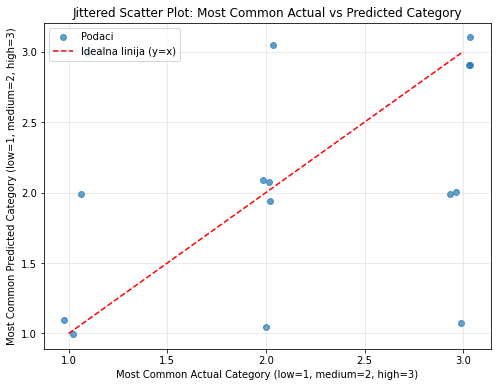

In [26]:
category_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
result_pre['most_common_category_numeric'] = result_pre['most_common_category'].map(category_mapping)
result_pre['most_common_predicted_category_numeric'] = result_pre['most_common_predicted_category'].map(category_mapping)


jitter_strength = 0.1
actual_with_jitter = result_pre['most_common_category_numeric'] + np.random.uniform(-jitter_strength, jitter_strength, len(result_pre))
predicted_with_jitter = result_pre['most_common_predicted_category_numeric'] + np.random.uniform(-jitter_strength, jitter_strength, len(result_pre))

plt.figure(figsize=(8, 6))
plt.scatter(actual_with_jitter, predicted_with_jitter, alpha=0.7, label="Podaci")

x_range = np.linspace(1, 3, 100)
plt.plot(x_range, x_range, color='red', linestyle='--', label="Idealna linija (y=x)")

plt.title("Jittered Scatter Plot: Most Common Actual vs Predicted Category")
plt.xlabel("Most Common Actual Category (low=1, medium=2, high=3)")
plt.ylabel("Most Common Predicted Category (low=1, medium=2, high=3)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 22. slajd 3. model

In [27]:
# FIZ. ZNAČAJKE PRE_STARTLE, FIZ. ZNAČAJKE STARTLE, PERFORMANSE STARTLE -> PERFORMANSE POST_STARTLE

pre_startle_values = all_features[all_features['Interval'] == 'pre_startle'].copy()

startle_values = all_features[all_features['Interval'] == 'startle'].copy()

combined = pre_startle_values.merge(startle_values, how='left', on=['Candidate', 'Startle'], suffixes=('_pre', '_startle'))

post_startle_values = all_features[all_features['Interval'] == 'post_startle'][['Candidate', 'Startle', 'mae_value']]

filtered_features_combined = combined.merge(post_startle_values, how='left', on=['Candidate', 'Startle'], suffixes=('', '_startle'))


In [28]:
mae_startle = pd.read_excel("mae_startle.xlsx")
df_post = mae_startle

post_startle_columns = [col for col in df_post.columns if "POST" in col]

all_post_startle_data = df_post[post_startle_columns].stack()

boundaries = pd.qcut(all_post_startle_data, q=3, labels=['Low', 'Medium', 'High'], retbins=True)[1]
print(f"Granice za sve post_startle kolone zajedno:")
print(f"Low do Medium: {boundaries[0]:.2f} - {boundaries[1]:.2f}")
print(f"Medium do High: {boundaries[1]:.2f} - {boundaries[2]:.2f}")
print(f"High do Max: {boundaries[2]:.2f} - {boundaries[3]:.2f}")
print("-" * 30)

for col in post_startle_columns:
    df_post[f'{col}_category'] = pd.cut(
        df_post[col],
        bins=boundaries,
        labels=['Low', 'Medium', 'High'],
        include_lowest=True
    )

#print(df_post)



Granice za sve post_startle kolone zajedno:
Low do Medium: 0.44 - 1.03
Medium do High: 1.03 - 1.60
High do Max: 1.60 - 5.39
------------------------------


In [29]:
def get_category_post(row):
    candidate_id = row['Candidate']
    startle_num = row['Startle']
    category_column = f"POST-STARTLE {startle_num}_category"
    return df_post.loc[df['ID'] == candidate_id, category_column].values[0]

filtered_features_combined['Category'] = filtered_features_combined.apply(get_category_post, axis=1)

print(filtered_features_combined)


    Candidate  Startle Interval_pre  IBI_Mean_pre  IBI_Std_pre  IBI_Slope_pre  \
0           1        1  pre_startle      0.704060     0.054429   1.196581e-02   
1           1        2  pre_startle      0.768519     0.030980   3.472222e-03   
2           1        3  pre_startle      0.754167     0.055248   1.157407e-03   
3           2        1  pre_startle      0.745940     0.036212  -4.572650e-03   
4           2        2  pre_startle      0.728704     0.014206   1.351852e-03   
5           2        3  pre_startle      0.735043     0.032054  -4.273504e-04   
6           3        1  pre_startle      0.711538     0.031082   3.205128e-03   
7           3        2  pre_startle      0.719676     0.016334   4.629630e-04   
8           3        3  pre_startle      0.709615     0.020430   1.495726e-03   
9           4        1  pre_startle      0.714103     0.040554   6.410256e-04   
10          4        2  pre_startle      0.727991     0.030244   1.854701e-03   
11          4        3  pre_

In [30]:
numeric_columns = ['IBI_Mean_pre', 'IBI_Std_pre', 'IBI_Slope_pre', 'HRV_SDNN_pre', 'HRV_RMSSD_pre', 
                   'EDA_Mean_pre', 'EDA_Std_pre', 'EDA_Slope_pre', 'EDA_Range_pre',
                   'IBI_Mean_startle', 'IBI_Std_startle', 'IBI_Slope_startle', 'HRV_SDNN_startle'
                   , 'HRV_RMSSD_startle', 
                   'EDA_Mean_startle', 'EDA_Std_startle', 'EDA_Slope_startle'
                   , 'EDA_Range_startle', 'mae_value_startle', 'mae_value']


correlation_matrix = filtered_features_combined[numeric_columns].corr()

#print(correlation_matrix)

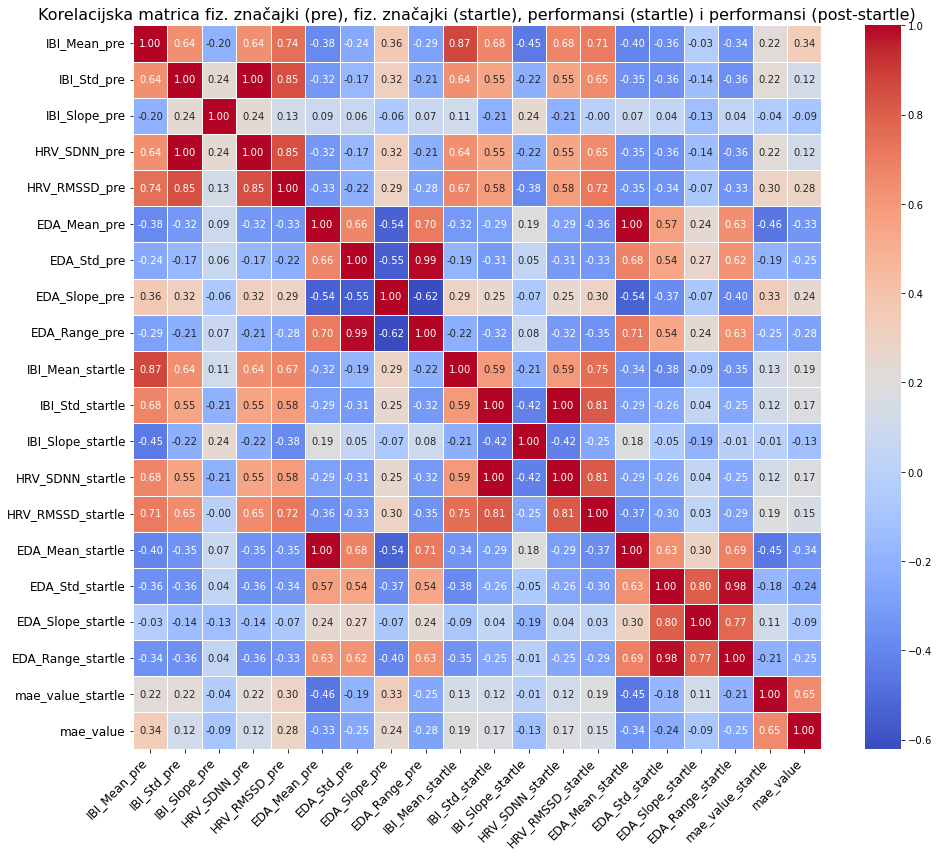

In [31]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, 
            annot_kws={"size": 10}, linewidths=0.5)

plt.title("Korelacijska matrica fiz. značajki (pre), fiz. značajki (startle), performansi (startle) i performansi (post-startle)", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()

plt.show()

# 22. slajd 3. model - logo

In [32]:
X = filtered_features_combined[['IBI_Mean_pre', 'IBI_Std_pre', 'IBI_Slope_pre', 'HRV_SDNN_pre'
                                , 'HRV_RMSSD_pre', 
                   'EDA_Mean_pre', 'EDA_Std_pre', 'EDA_Slope_pre', 'EDA_Range_pre',
                   'IBI_Mean_startle', 'IBI_Std_startle', 'IBI_Slope_startle', 'HRV_SDNN_startle'
                   , 'HRV_RMSSD_startle', 
                   'EDA_Mean_startle', 'EDA_Std_startle', 'EDA_Slope_startle'
                   , 'EDA_Range_startle', 'mae_value_startle'
                      ]]
y = filtered_features_combined['Category']
candidates = filtered_features_combined['Candidate']

lda = LinearDiscriminantAnalysis()

# Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()  
accuracies = []
predictions = []  

for train_index, test_index in logo.split(X, y, groups=candidates):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lda.fit(X_train, y_train)
    
    y_pred = lda.predict(X_test)
    
    predictions.extend(y_pred)  
    
    accuracies.append(accuracy_score(y_test, y_pred))  

mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Prosječna točnost LDA modela s LOO-GO: {mean_accuracy:.2f}")

filtered_features_combined['Predicted_Category'] = predictions
#print(filtered_features_combined)

Prosječna točnost LDA modela s LOO-GO: 0.44


# 22. slajd 3. model - loo

In [33]:
X = filtered_features_combined[['IBI_Mean_pre', 'IBI_Std_pre', 'IBI_Slope_pre', 'HRV_SDNN_pre'
                                , 'HRV_RMSSD_pre', 
                   'EDA_Mean_pre', 'EDA_Std_pre', 'EDA_Slope_pre', 'EDA_Range_pre',
                   'IBI_Mean_startle', 'IBI_Std_startle', 'IBI_Slope_startle', 'HRV_SDNN_startle'
                   , 'HRV_RMSSD_startle', 
                   'EDA_Mean_startle', 'EDA_Std_startle', 'EDA_Slope_startle'
                   , 'EDA_Range_startle', 'mae_value_startle'
                      ]]
y = filtered_features_combined['Category']
candidates = filtered_features_combined['Candidate']

lda = LinearDiscriminantAnalysis()

loo = LeaveOneOut()
accuracies = []
predictions = [] 

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lda.fit(X_train, y_train)
    
    y_pred = lda.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    predictions.append(y_pred[0])  
    

mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Prosječna točnost LDA modela s LOOCV: {mean_accuracy:.2f}")


filtered_features_combined['Predicted_Category'] = predictions
#print(filtered_features_combined)

Prosječna točnost LDA modela s LOOCV: 0.44


In [34]:
result_post = filtered_features_combined.groupby('Candidate').agg(
    most_common_category=('Category', lambda x: x.mode().iloc[0]),
    most_common_predicted_category=('Predicted_Category', lambda x: x.mode().iloc[0])
).reset_index()


accuracy = (result_post['most_common_category'] == result_post['most_common_predicted_category']).mean() * 100

print(f'Accuracy: {accuracy:.2f}%')
print(result_post)



Accuracy: 46.67%
    Candidate most_common_category most_common_predicted_category
0           1                 High                            Low
1           2                 High                         Medium
2           3                 High                            Low
3           4                  Low                         Medium
4           5                 High                           High
5           7               Medium                         Medium
6           9                  Low                            Low
7          11                 High                           High
8          12               Medium                            Low
9          13                 High                           High
10         15               Medium                           High
11         16                 High                           High
12         18                 High                           High
13         19               Medium                         

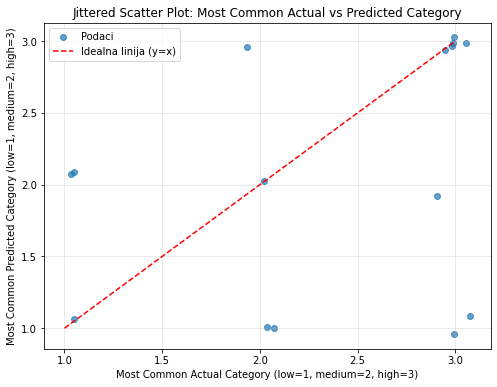

In [35]:
category_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
result_post['most_common_category_numeric'] = result_post['most_common_category'].map(category_mapping)
result_post['most_common_predicted_category_numeric'] = result_post['most_common_predicted_category'].map(category_mapping)


jitter_strength = 0.1
actual_with_jitter = result_post['most_common_category_numeric'] + np.random.uniform(-jitter_strength, jitter_strength, len(result_post))
predicted_with_jitter = result_post['most_common_predicted_category_numeric'] + np.random.uniform(-jitter_strength, jitter_strength, len(result_post))

plt.figure(figsize=(8, 6))
plt.scatter(actual_with_jitter, predicted_with_jitter, alpha=0.7, label="Podaci")

x_range = np.linspace(1, 3, 100)
plt.plot(x_range, x_range, color='red', linestyle='--', label="Idealna linija (y=x)")

plt.title("Jittered Scatter Plot: Most Common Actual vs Predicted Category")
plt.xlabel("Most Common Actual Category (low=1, medium=2, high=3)")
plt.ylabel("Most Common Predicted Category (low=1, medium=2, high=3)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
